In [1]:
import os
import zipfile
import shutil
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras.metrics import Precision, Recall
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
base_dir = '/kaggle/input/fruit-and-vegetable-image-recognition'

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
def num_of_classes(folder_dir, folder_name):
    # Filter to include only directories
    classes = [class_name for class_name in os.listdir(folder_dir) 
               if os.path.isdir(os.path.join(folder_dir, class_name))]
    
    # Print the number of classes
    print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 
                  'blue', attrs=['bold']))
    
    # Optionally return the number of classes
    return len(classes)

# Example usage:
train_classes = num_of_classes(train_dir, "train")
validation_classes = num_of_classes(validation_dir, "validation")
test_classes = num_of_classes(test_dir, "test")

Number of classes in train folder: 36
Number of classes in validation folder: 36
Number of classes in test folder: 36


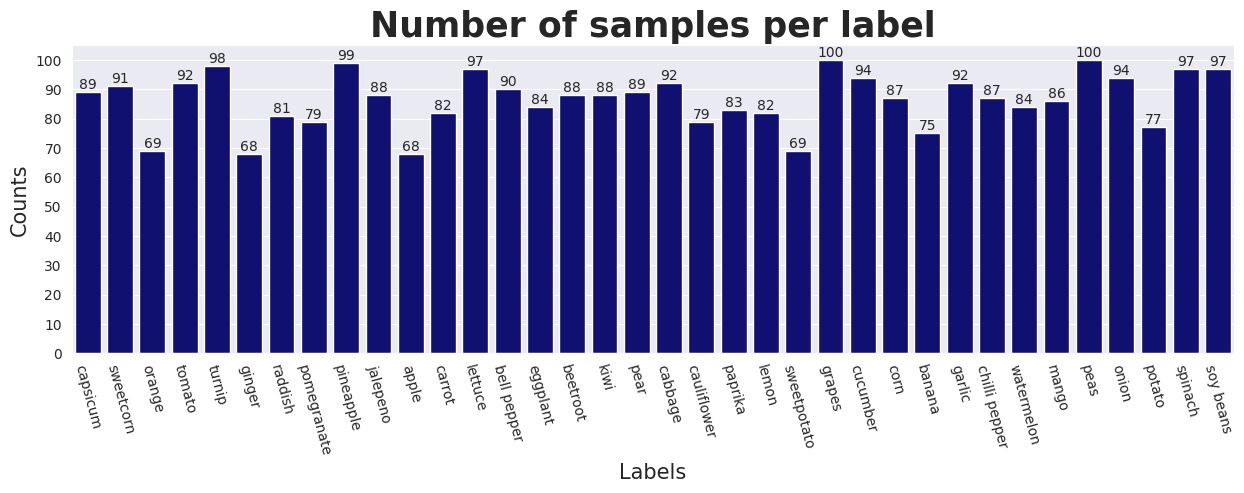

In [6]:
# work on train folder and count number of samples per each class
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [7]:
def create_df(folder_path):
    """
    Create a DataFrame with file paths and class labels.

    Args:
        folder_path (str): Path to the folder containing class subdirectories.

    Returns:
        pd.DataFrame: A DataFrame with columns ['file_path', 'label'].
    """
    all_images = []
    
    # Get class names (subdirectory names)
    classes = [class_name for class_name in os.listdir(folder_path) 
               if os.path.isdir(os.path.join(folder_path, class_name))]
    
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        
        # Add (file_path, label) tuples for each file in the class directory
        all_images.extend([(os.path.join(class_path, file_name), class_name) 
                           for file_name in os.listdir(class_path) 
                           if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))])
    
    # Create the DataFrame
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

# Example usage:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

# Preview the DataFrame
print(train_df.head())
print(train_df.tail())

                                           file_path     label
0  /kaggle/input/fruit-and-vegetable-image-recogn...  capsicum
1  /kaggle/input/fruit-and-vegetable-image-recogn...  capsicum
2  /kaggle/input/fruit-and-vegetable-image-recogn...  capsicum
3  /kaggle/input/fruit-and-vegetable-image-recogn...  capsicum
4  /kaggle/input/fruit-and-vegetable-image-recogn...  capsicum
                                              file_path      label
3110  /kaggle/input/fruit-and-vegetable-image-recogn...  soy beans
3111  /kaggle/input/fruit-and-vegetable-image-recogn...  soy beans
3112  /kaggle/input/fruit-and-vegetable-image-recogn...  soy beans
3113  /kaggle/input/fruit-and-vegetable-image-recogn...  soy beans
3114  /kaggle/input/fruit-and-vegetable-image-recogn...  soy beans


In [8]:
print(colored(f'Number of samples in train : {len(train_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'green', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


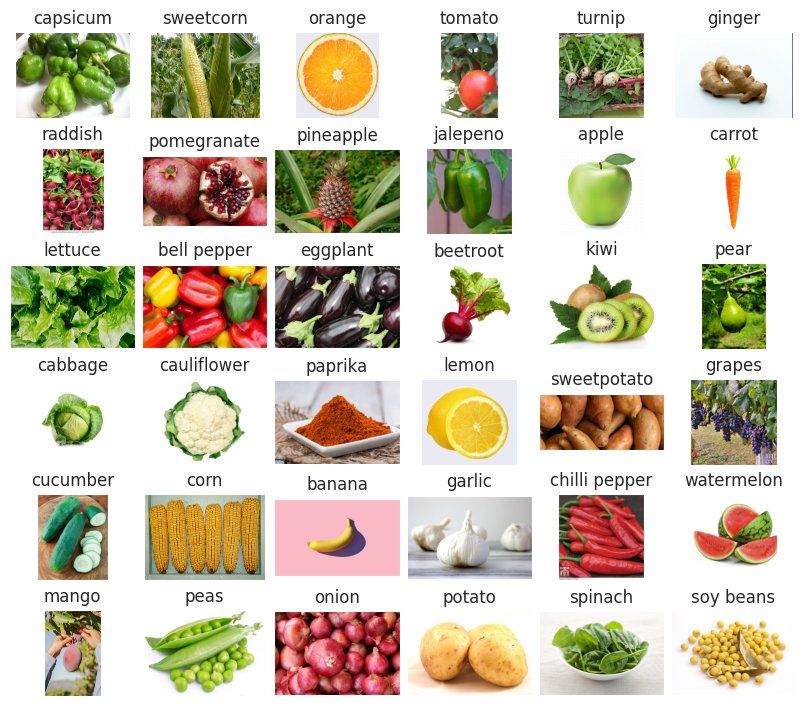

In [9]:
#Show an image per each class
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Train generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

# Validation generator without augmentation
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

# Test generator without augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)


Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_transfer_model(num_classes):
    # Load MobileNetV2 with pretrained weights, exclude top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers on top
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)  # Use base model in inference mode
    x = GlobalAveragePooling2D()(x)        # Global Average Pooling to replace Flatten()
    x = Dense(256, activation='relu')(x)   # Fully connected layer
    x = Dropout(0.5)(x)                    # Dropout to prevent overfitting
    outputs = Dense(num_classes, activation='softmax')(x)  # Softmax output layer
    
    # Create the complete model
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy','Precision', 'Recall'])
    return model


# Create the model
num_classes = len(train_generator.class_indices)  # Get the number of classes from the generator
transfer_model = create_transfer_model(num_classes)

# Summary of the model
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,595,172 (9.90 MB)

 Trainable params: 337,188 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

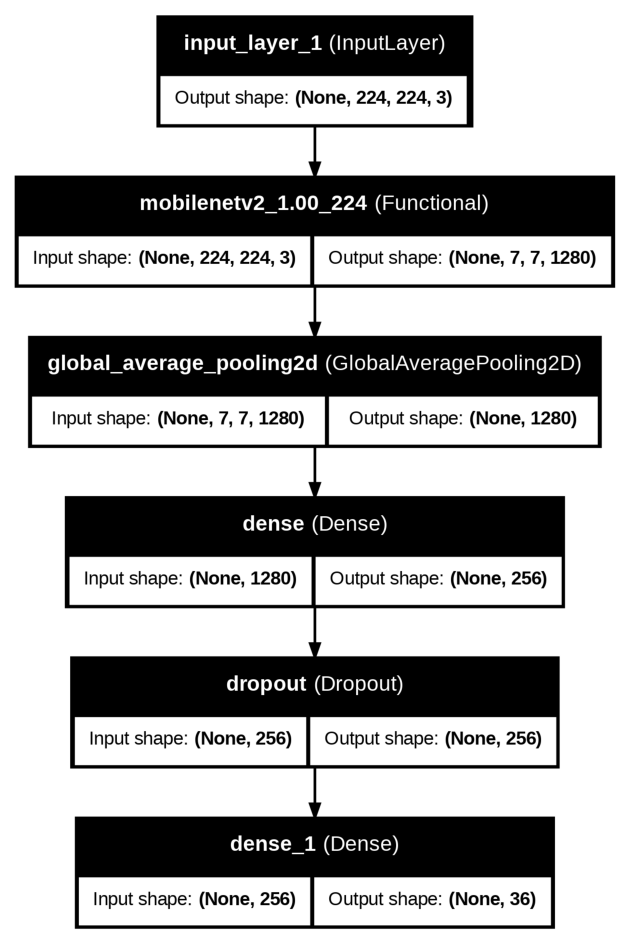

In [12]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(transfer_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# To display the plot inline (if you are using Jupyter Notebook or IPython)
import matplotlib.pyplot as plt
img = plt.imread('model_architecture.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [13]:
# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose = 1)
    ]
)




Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - Precision: 0.6147 - Recall: 0.0914 - accuracy: 0.2724 - loss: 2.8353 - val_Precision: 0.9213 - val_Recall: 0.7009 - val_accuracy: 0.8262 - val_loss: 0.6222
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - Precision: 0.8183 - Recall: 0.5422 - accuracy: 0.6836 - loss: 1.0615 - val_Precision: 0.9417 - val_Recall: 0.8291 - val_accuracy: 0.8775 - val_loss: 0.3832
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 999ms/step - Precision: 0.8460 - Recall: 0.6552 - accuracy: 0.7473 - loss: 0.8160 - val_Precision: 0.9308 - val_Recall: 0.8433 - val_accuracy: 0.8803 - val_loss: 0.3326
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - Precision: 0.8494 - Recall: 0.6931 - accuracy: 0.7748 - loss: 0.7075 - val_Precision: 0.9388 - val_Recall: 0.8746 - val_accuracy: 0.9174 - val_loss: 0.2857
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - Precision: 0.8749 - Recall: 0.7345 - accuracy: 0.8038 - loss: 0.6012 - val_Precision: 0.9371 - val_Recall: 0

In [14]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)

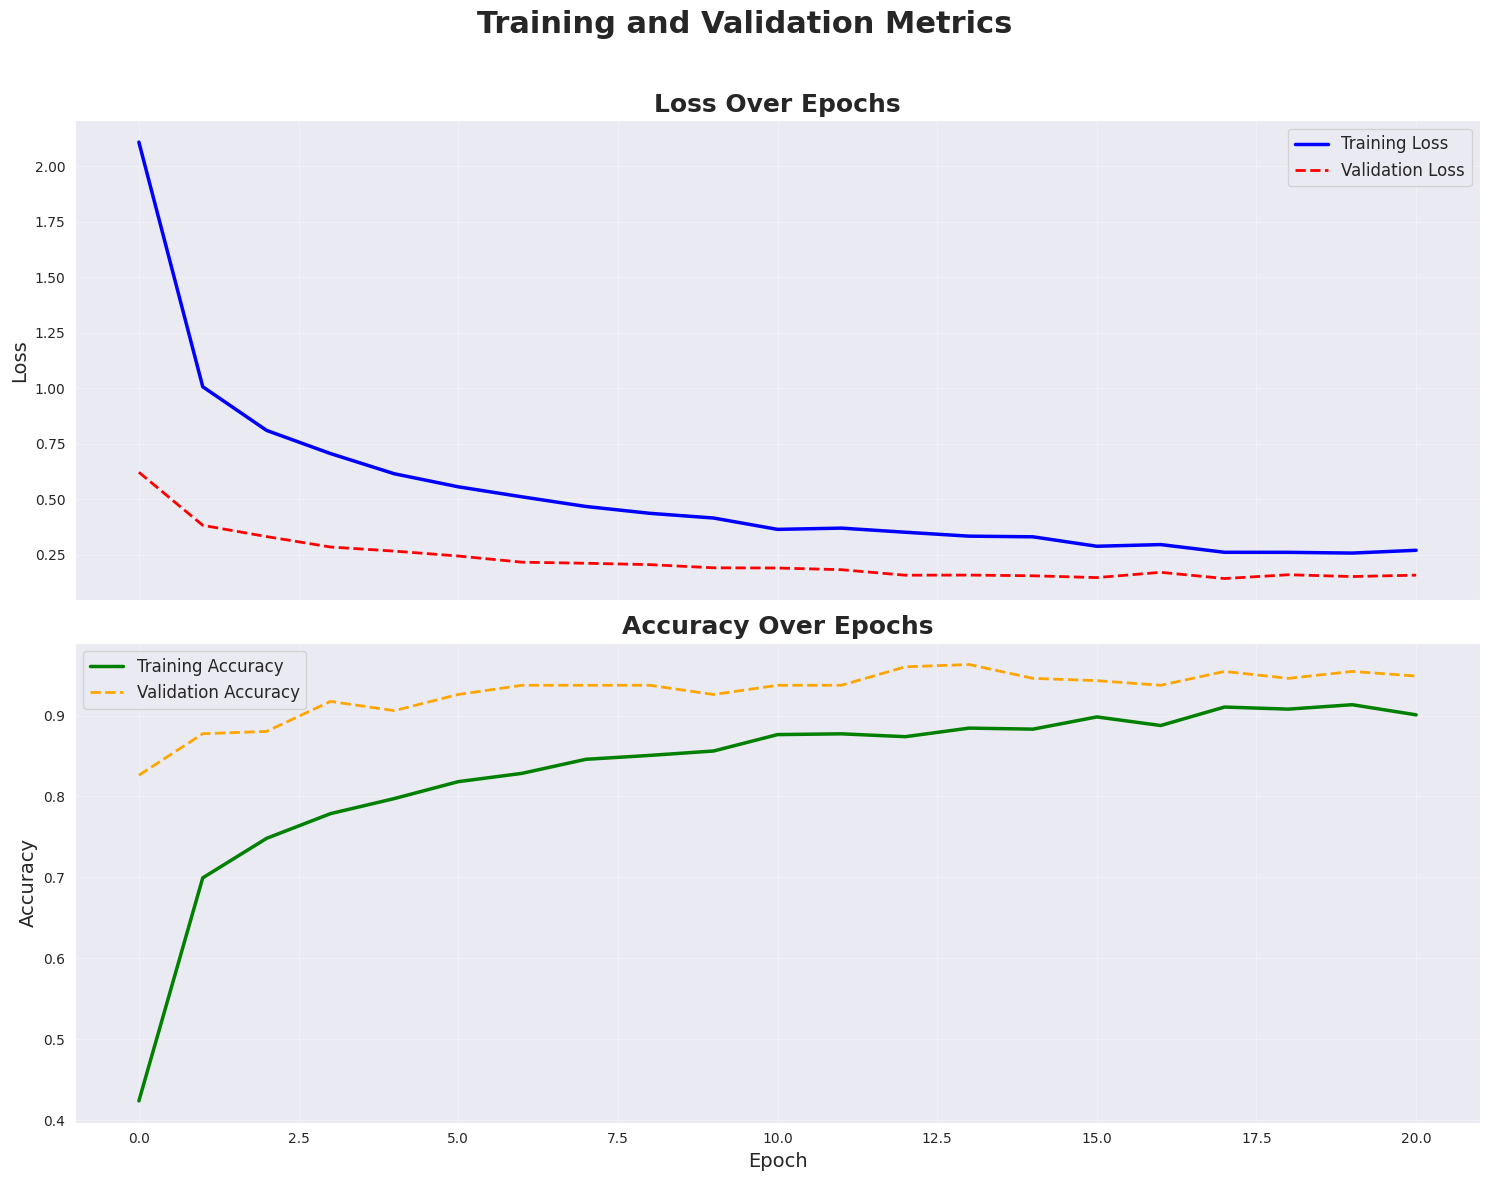

In [15]:
# Define x-axis values
x = np.arange(len(result_df))

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Define common line properties
line_width_main = 2.5
line_width_secondary = 2

# AX[0]: Loss Plot
ax[0].plot(x, result_df.loss, label='Training Loss', linewidth=line_width_main, color='blue')
ax[0].plot(x, result_df.val_loss, label='Validation Loss', linewidth=line_width_secondary, linestyle='--', color='red')
ax[0].set_title('Loss Over Epochs', fontsize=18, fontweight='bold')
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=12)
ax[0].grid(alpha=0.3)

# AX[1]: Accuracy Plot
ax[1].plot(x, result_df.accuracy, label='Training Accuracy', linewidth=line_width_main, color='green')
ax[1].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=line_width_secondary, linestyle='--', color='orange')
ax[1].set_title('Accuracy Over Epochs', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=12)
ax[1].grid(alpha=0.3)

# Set overall title
fig.suptitle('Training and Validation Metrics', fontsize=22, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

In [16]:
results = transfer_model.evaluate(test_generator)
print("Results:", results)

# Access individual metrics
test_loss = results[0]  # First value is the loss
test_accuracy = results[1]  # Second value is accuracy
# Add other metrics if defined, e.g.:
if len(results) > 2:
    test_precision = results[2]
    test_recall = results[3]
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - Precision: 0.9766 - Recall: 0.9656 - accuracy: 0.9667 - loss: 0.1367
Results: [0.14235636591911316, 0.9554317593574524, 0.9715909361839294, 0.9526462554931641]
Test Precision: 0.9716
Test Recall: 0.9526
Test Loss: 0.1424
Test Accuracy: 0.9554


In [17]:
# Predict the label of the test_images
pred = transfer_model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_generator.classes]

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 992ms/step


In [18]:
labels.items()

dict_items([(0, 'apple'), (1, 'banana'), (2, 'beetroot'), (3, 'bell pepper'), (4, 'cabbage'), (5, 'capsicum'), (6, 'carrot'), (7, 'cauliflower'), (8, 'chilli pepper'), (9, 'corn'), (10, 'cucumber'), (11, 'eggplant'), (12, 'garlic'), (13, 'ginger'), (14, 'grapes'), (15, 'jalepeno'), (16, 'kiwi'), (17, 'lemon'), (18, 'lettuce'), (19, 'mango'), (20, 'onion'), (21, 'orange'), (22, 'paprika'), (23, 'pear'), (24, 'peas'), (25, 'pineapple'), (26, 'pomegranate'), (27, 'potato'), (28, 'raddish'), (29, 'soy beans'), (30, 'spinach'), (31, 'sweetcorn'), (32, 'sweetpotato'), (33, 'tomato'), (34, 'turnip'), (35, 'watermelon')])

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step


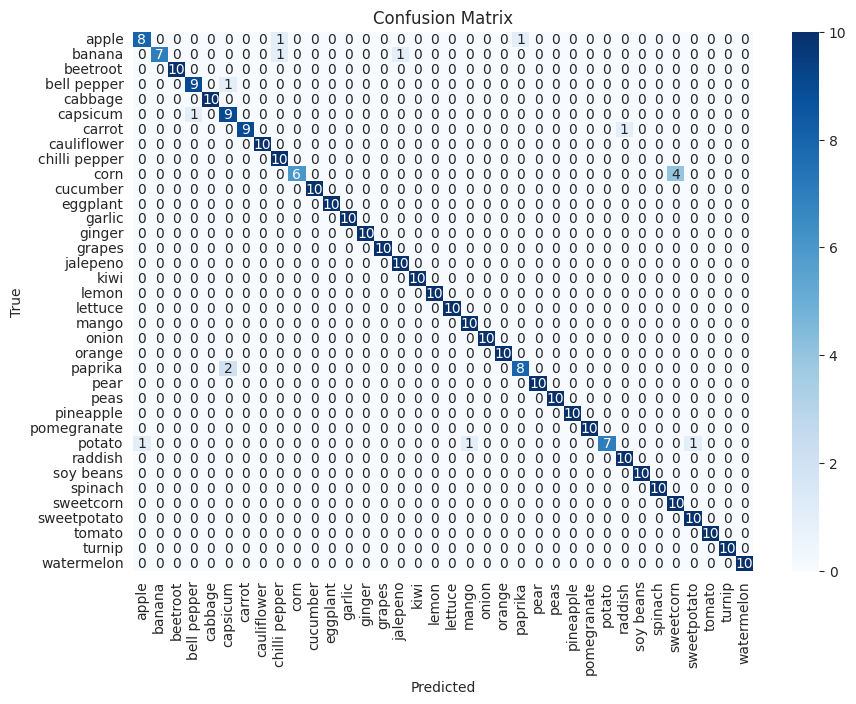

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels from the test set
true_labels = test_generator.classes

# Get predicted labels from the model
predictions = transfer_model.predict(test_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


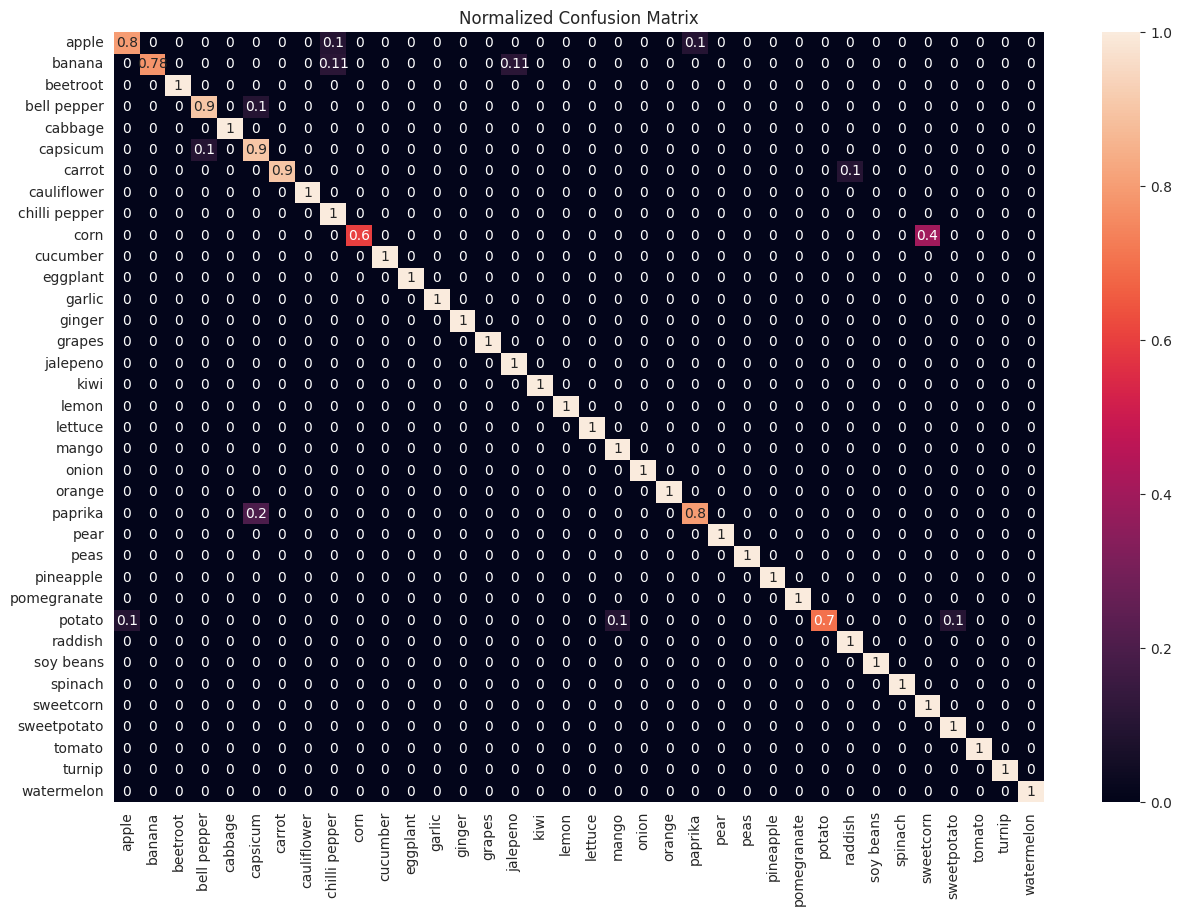

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Print classification report for precision, recall, F1-score
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))


               precision    recall  f1-score   support

        apple       0.89      0.80      0.84        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.75      0.90      0.82        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.83      1.00      0.91        10
         corn       1.00      0.60      0.75        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       0.91      1.00      0.95        10
         kiwi       1.00      1.00      1.00        10
        l

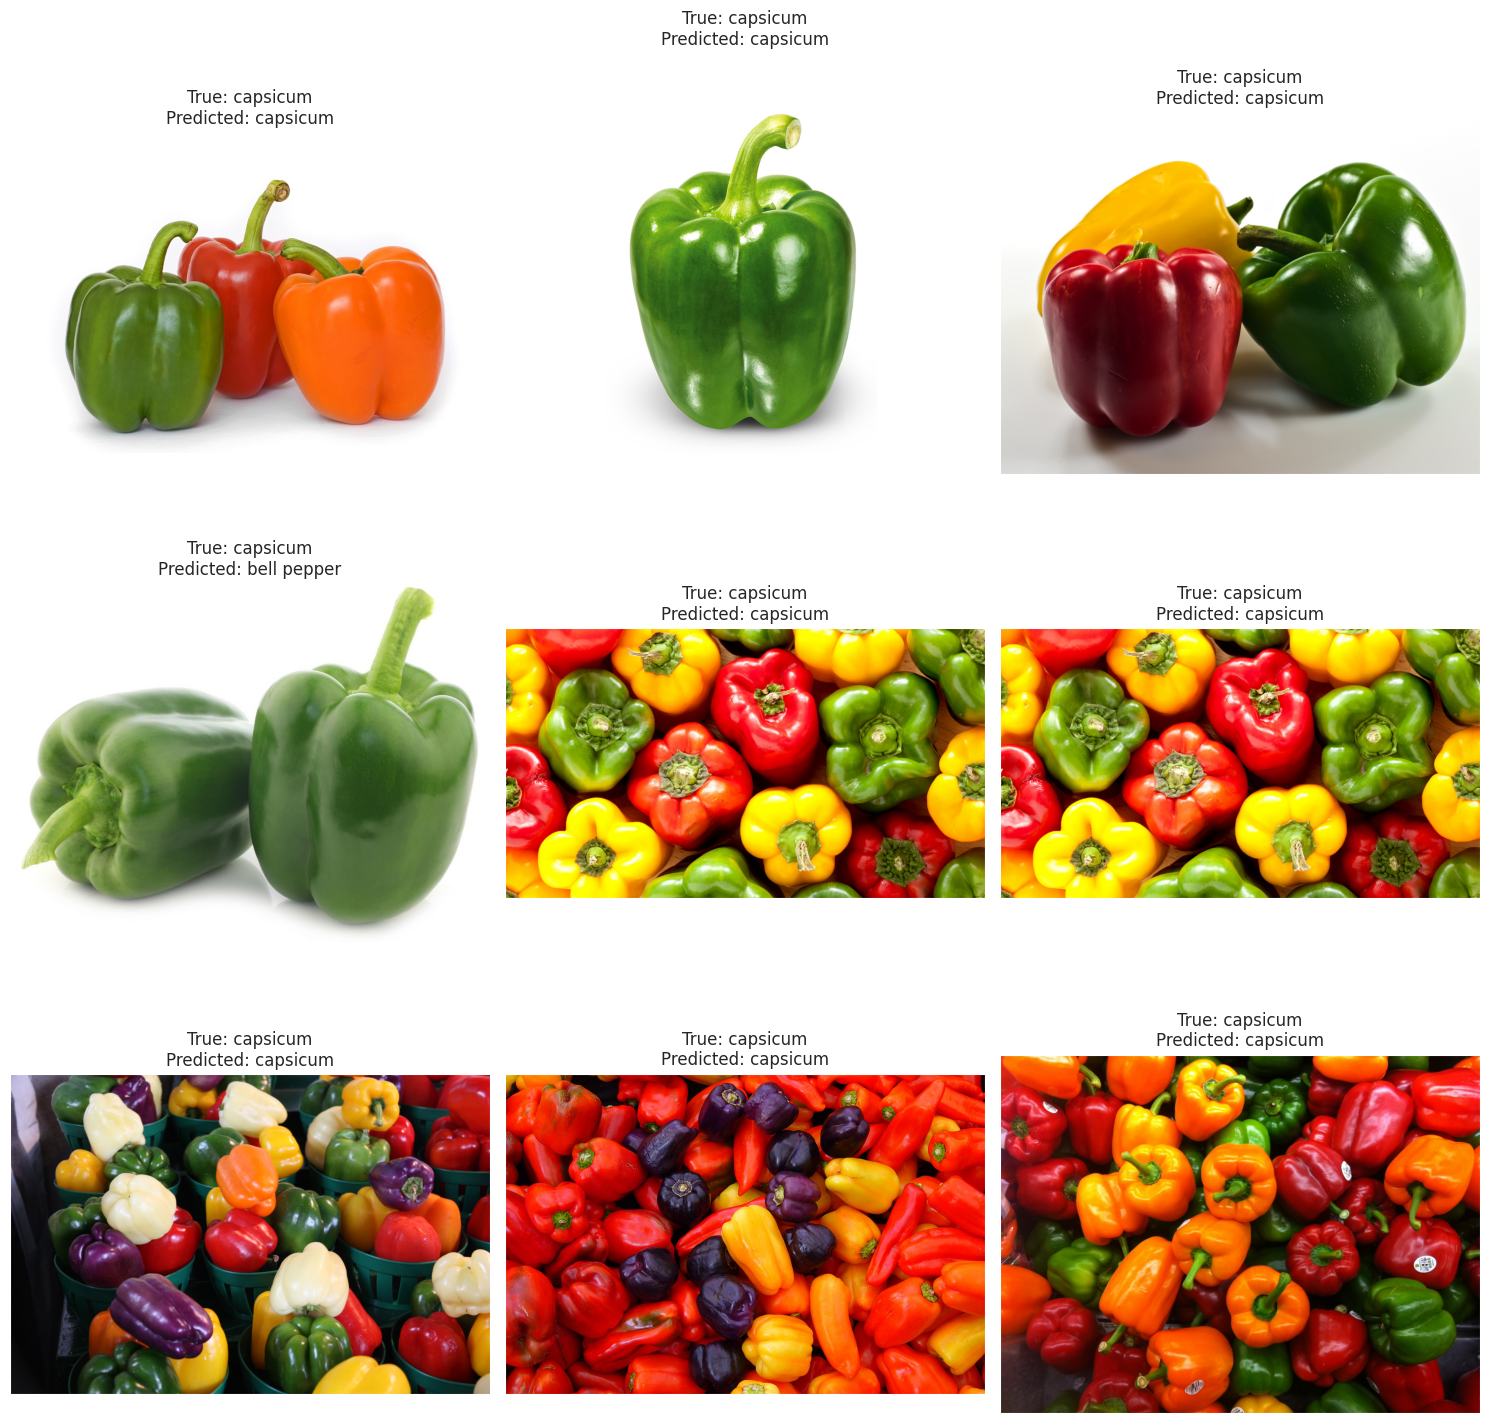

In [22]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.file_path.iloc[i]))
    ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [23]:
def output(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=transfer_model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

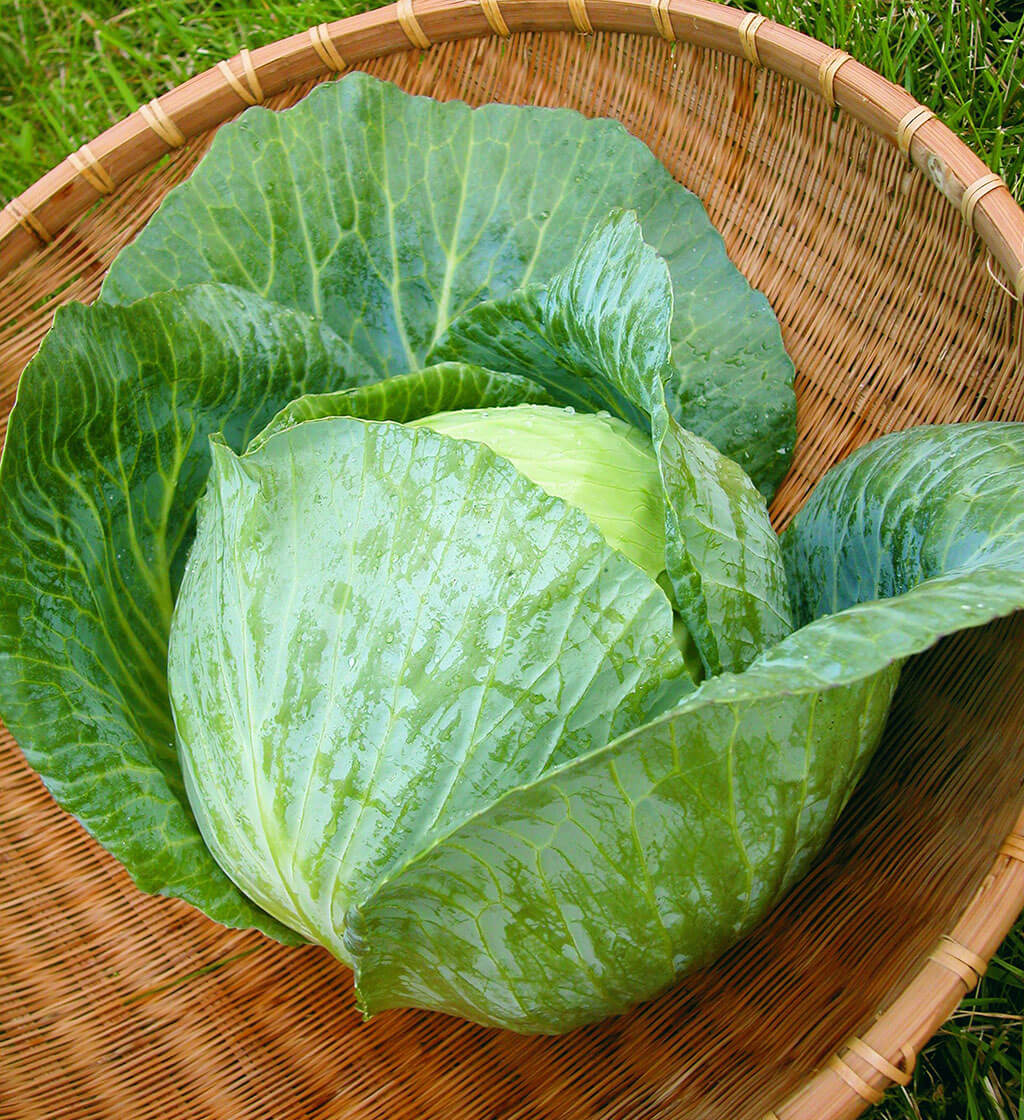

In [24]:
from IPython.display import display
from PIL import Image

location = '../input/fruit-and-vegetable-image-recognition/test/cabbage/Image_1.jpg'
display(Image.open(location))

In [25]:
img = output(location)
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'cabbage'

In [26]:
transfer_model.save('Fruits&VegetablesModel.h5')